# Data preparation

In this section I import the data provided by eversense from an excel file into a single dataframe, I implement a smooth glucose calibration and I select the data corresponding to my fast day.

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import numpy as np

all_data = pd.read_excel('All Events.xlsx',sheet_name = 'Sensor Glucose').drop(columns = ['SensorID','UnitMeasureVal'])
# I'm only inteseted in 2 days of data. Cut out most of the data immediately.
date_window = [datetime(2024,7,1),datetime(2024,7,6)]
all_data = all_data[(pd.to_datetime(all_data['EventDateStr'])>=date_window[0]) & (pd.to_datetime(all_data['EventDateStr'])<=date_window[-1])].copy()
all_data['EventType'] = 'glucose_measurement'

#include the insuling injection, eating and sport events
temp = pd.read_excel('All Events.xlsx',sheet_name = 'Patient Events')
temp = temp[(pd.to_datetime(temp['EventDateStr'])>=date_window[0]) & (pd.to_datetime(temp['EventDateStr'])<=date_window[-1])].copy()
temp.loc[temp['EventType'] == 'Insulin','UnitValue'] = temp.loc[temp['EventType'] == 'Insulin','UnitValue'].apply(lambda x: x[:-6])
temp.loc[temp['EventType'] == 'Meal','UnitValue'] = temp.loc[temp['EventType'] == 'Meal','UnitValue'].apply(lambda x: x[7:-6])
temp.loc[temp['EventType'] == 'Exercise','UnitValue'] = temp.loc[temp['EventType'] == 'Exercise','UnitValue'].apply(lambda x: x[10:-4])
temp.loc[temp['EventSubType'] == 'Type: Rapid Acting','EventType'] = 'rapid_insulin_u'
temp.loc[temp['EventSubType'] == 'Type: Long Acting','EventType'] = 'long_insulin_u'
# I took note of what I ate (sugar, chocolate, sugar, sugar), but had to look is up in my phone.
temp.loc[temp['EventType'] == 'Meal','EventType'] = ['rapid_glucose_g','slow_glucose_g','rapid_glucose_g','rapid_glucose_g']
temp.loc[temp['EventSubType'] == 'Intensity: High','EventType'] = 'high_exercise_min'
temp.loc[temp['EventSubType'] == 'Intensity: Medium','EventType'] = 'medium_exercise_min'
temp = temp.drop(columns = ['EventSubType']).rename(columns = {'UnitValue':'Value'})
all_data = pd.concat([all_data,temp])

#include the calibrations
temp = pd.read_excel('All Events.xlsx',sheet_name = 'Blood Glucose').drop(columns = ['UnitMeasureVal']).drop(columns = ['CalibrationMsg'])
temp = temp[(pd.to_datetime(temp['EventDateStr'])>=date_window[0]) & (pd.to_datetime(temp['EventDateStr'])<=date_window[-1])].copy()
temp['EventType'] = 'calibration'
all_data = pd.concat([all_data,temp])

all_data['Value'] = all_data['Value'].astype(float)
all_data.index = pd.to_datetime(all_data['EventDateStr'] + ' ' + all_data['EventTimeStr'])
all_data = all_data.sort_index()
all_data

,EventDateStr,EventTimeStr,Value,EventType
2024-07-01 00:01:00,01-July-2024,12:01 AM,13.2,glucose_measurement
2024-07-01 00:05:00,01-July-2024,12:05 AM,1.0,rapid_insulin_u
2024-07-01 00:06:00,01-July-2024,12:06 AM,12.7,glucose_measurement
2024-07-01 00:11:00,01-July-2024,12:11 AM,12.4,glucose_measurement
2024-07-01 00:16:00,01-July-2024,12:16 AM,12.7,glucose_measurement
...,...,...,...,...
2024-07-06 23:38:00,06-July-2024,11:38 PM,8.6,glucose_measurement
2024-07-06 23:43:00,06-July-2024,11:43 PM,8.3,glucose_measurement
2024-07-06 23:48:00,06-July-2024,11:48 PM,8.2,glucose_measurement
2024-07-06 23:53:00,06-July-2024,11:53 PM,7.9,glucose_measurement


In [2]:
for type in all_data['EventType'].unique():
    if type != 'glucose_measurement':
        display(all_data.loc[all_data['EventType'] == type,['Value', 'EventType']])

,Value,EventType
2024-07-01 00:05:00,1.0,rapid_insulin_u
2024-07-01 06:48:00,4.0,rapid_insulin_u
2024-07-01 08:22:00,4.0,rapid_insulin_u
2024-07-01 09:46:00,2.0,rapid_insulin_u
2024-07-01 12:15:00,6.0,rapid_insulin_u
2024-07-01 14:16:00,2.0,rapid_insulin_u
2024-07-01 16:46:00,4.0,rapid_insulin_u
2024-07-01 19:21:00,2.0,rapid_insulin_u
2024-07-01 19:40:00,4.0,rapid_insulin_u
2024-07-02 00:48:00,1.0,rapid_insulin_u


,Value,EventType
2024-07-01 06:48:00,12.2,calibration
2024-07-02 07:32:00,7.2,calibration
2024-07-03 06:40:00,12.1,calibration
2024-07-04 07:54:00,4.1,calibration
2024-07-05 07:40:00,4.2,calibration
2024-07-06 08:59:00,4.9,calibration


,Value,EventType
2024-07-01 07:09:00,18.0,long_insulin_u
2024-07-02 09:16:00,18.0,long_insulin_u
2024-07-03 06:42:00,17.0,long_insulin_u
2024-07-04 07:58:00,17.0,long_insulin_u
2024-07-05 07:42:00,17.0,long_insulin_u
2024-07-06 09:01:00,18.0,long_insulin_u


,Value,EventType
2024-07-03 12:10:00,40.0,medium_exercise_min


,Value,EventType
2024-07-03 13:38:00,10.0,rapid_glucose_g
2024-07-03 17:56:00,10.0,rapid_glucose_g
2024-07-04 04:36:00,10.0,rapid_glucose_g


,Value,EventType
2024-07-03 18:00:00,60.0,high_exercise_min


,Value,EventType
2024-07-03 22:31:00,10.0,slow_glucose_g


In [3]:
all_data[(all_data.index.duplicated(keep = False))]

,EventDateStr,EventTimeStr,Value,EventType
2024-07-01 06:48:00,01-July-2024,06:48 AM,12.2,calibration
2024-07-01 06:48:00,01-July-2024,06:48 AM,4.0,rapid_insulin_u
2024-07-01 09:46:00,01-July-2024,09:46 AM,5.5,glucose_measurement
2024-07-01 09:46:00,01-July-2024,09:46 AM,2.0,rapid_insulin_u
2024-07-01 14:16:00,01-July-2024,02:16 PM,9.7,glucose_measurement
2024-07-01 14:16:00,01-July-2024,02:16 PM,2.0,rapid_insulin_u
2024-07-01 16:46:00,01-July-2024,04:46 PM,4.0,rapid_insulin_u
2024-07-01 16:46:00,01-July-2024,04:46 PM,7.2,glucose_measurement
2024-07-01 19:21:00,01-July-2024,07:21 PM,7.2,glucose_measurement
2024-07-01 19:21:00,01-July-2024,07:21 PM,2.0,rapid_insulin_u


In [4]:
all_data['EventType'].unique()

array(['glucose_measurement', 'rapid_insulin_u', 'calibration',
       'long_insulin_u', 'medium_exercise_min', 'rapid_glucose_g',
       'high_exercise_min', 'slow_glucose_g'], dtype=object)

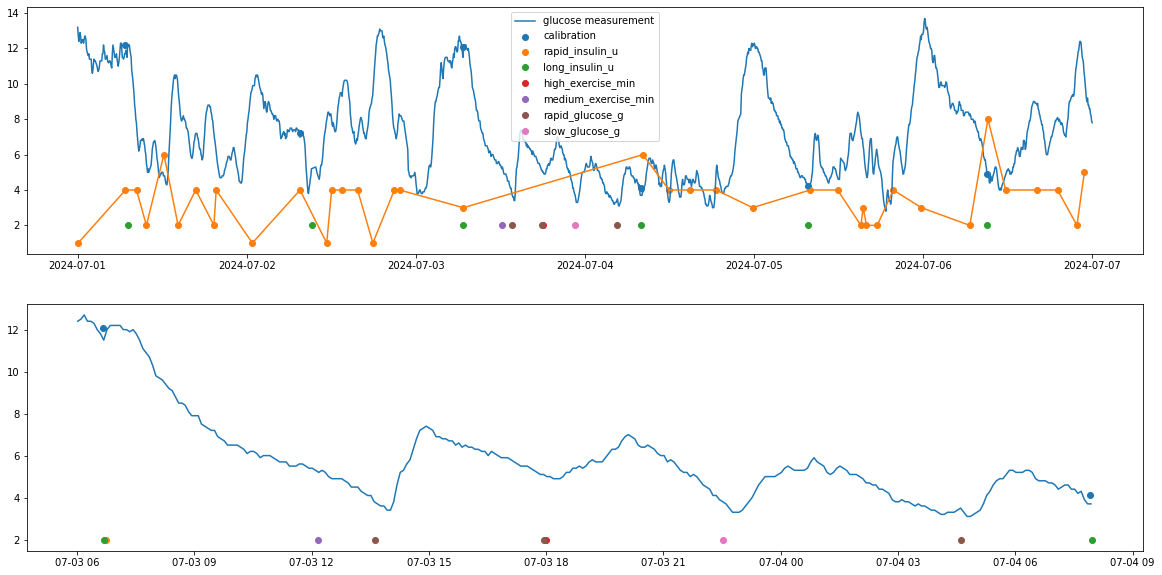

In [5]:
fig, axs = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)

data = all_data[all_data['EventType'] == 'glucose_measurement'].copy()
axs[0].plot(data.index,data['Value'], label = 'glucose measurement')

data = all_data[all_data['EventType'] == 'calibration'].copy()
axs[0].scatter(data.index,data['Value'], label = 'calibration')

type = 'rapid_insulin_u'
data = all_data[all_data['EventType'] == type].copy()
axs[0].scatter(data.index,data['Value'], label = type)
axs[0].plot(data.index,data['Value'])
for type in ['long_insulin_u', 'high_exercise_min', 'medium_exercise_min', 'rapid_glucose_g', 'slow_glucose_g']:
    data = all_data[all_data['EventType'] == type].copy()
    axs[0].scatter(data.index,[2]*len(data), label = type)

axs[0].legend()

fast_start = datetime(2024,7,3,6)
fast_end = datetime(2024,7,4,8)
data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == 'glucose_measurement')].copy()
axs[1].plot(data.index,data['Value'], label = 'glucose measurement')

data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == 'calibration')].copy()
axs[1].scatter(data.index,data['Value'], label = 'calibration')

for type in ['rapid_insulin_u','long_insulin_u', 'high_exercise_min', 'medium_exercise_min', 'rapid_glucose_g', 'slow_glucose_g']:
    data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == type)].copy()
    axs[1].scatter(data.index,[2]*len(data), label = type)

The device is calibrated about once a day. The next 3 (my guess) measurements are then incrementally adjusted to catch up with the calibration. I model this by breaking the data into calibration intervals (time intervals between two calibrations) and adding a linear (in time) correction to the measured glucose. The correction is set to be zero 3 measurements after each calibration and match the calibration at the measurement that comes just before the next measurement.

In [9]:
# Compute a calibration factor. The 3 measurements that come just after a calibration are already adjusted, they will be adjusted with a diminishing amplitude. The glucose correction is multiplied by (2/3,1/3,0).
all_data.loc[all_data['EventType'] == 'glucose_measurement','calibration_factor'] = 1
for cal in all_data[all_data['EventType'] == 'calibration'].index:
    indices = all_data.loc[(all_data['EventType'] == 'glucose_measurement') & (all_data.index >= cal),'calibration_factor'].head(3).index
    length = len(indices)
    all_data.loc[all_data.index.isin(indices),'calibration_factor'] = np.arange(2,-length+2,-1)/3

In [51]:
# Here I computed the calibrated glucose measurement.
zeros = all_data[(all_data['EventType'] == 'glucose_measurement') & (all_data['calibration_factor'] == 0)].index
for ind, z in enumerate(zeros[1:]):
    data = all_data[(all_data['EventType'] == 'glucose_measurement') & (all_data.index <= z) & (all_data.index >= zeros[ind])].copy()
    data = pd.concat([data,pd.DataFrame([],index = all_data[(all_data['EventType'] == 'calibration') & (all_data.index <= z)  & (all_data.index >= zeros[ind])].index,columns = data.columns)]).sort_index()
    data['Value'] = data['Value'].interpolate(method = 'time')
    data['elapsed_time'] = (data.index-data.index[0]).total_seconds()
    correction_slope = ((all_data.loc[(all_data['EventType'] == 'calibration') & (all_data.index <= z)  & (all_data.index >= zeros[ind]),'Value'] - data.loc[all_data[(all_data['EventType'] == 'calibration') & (all_data.index <= z)  & (all_data.index >= zeros[ind])].index,'Value'])/(z-zeros[ind]).total_seconds()).values[0]
    data['calibration_correction'] = correction_slope*data['elapsed_time']
    data['calibrated_glucose'] = data['Value']+data['calibration_factor']*data['calibration_correction']
    all_data.loc[(all_data['EventType'] == 'glucose_measurement') & (all_data.index <= z) & (all_data.index >= zeros[ind]),'calibrated_glucose'] = data.loc[data.index.isin(all_data[(all_data['EventType'] == 'glucose_measurement') & (all_data.index <= z) & (all_data.index >= zeros[ind])].index),'calibrated_glucose']

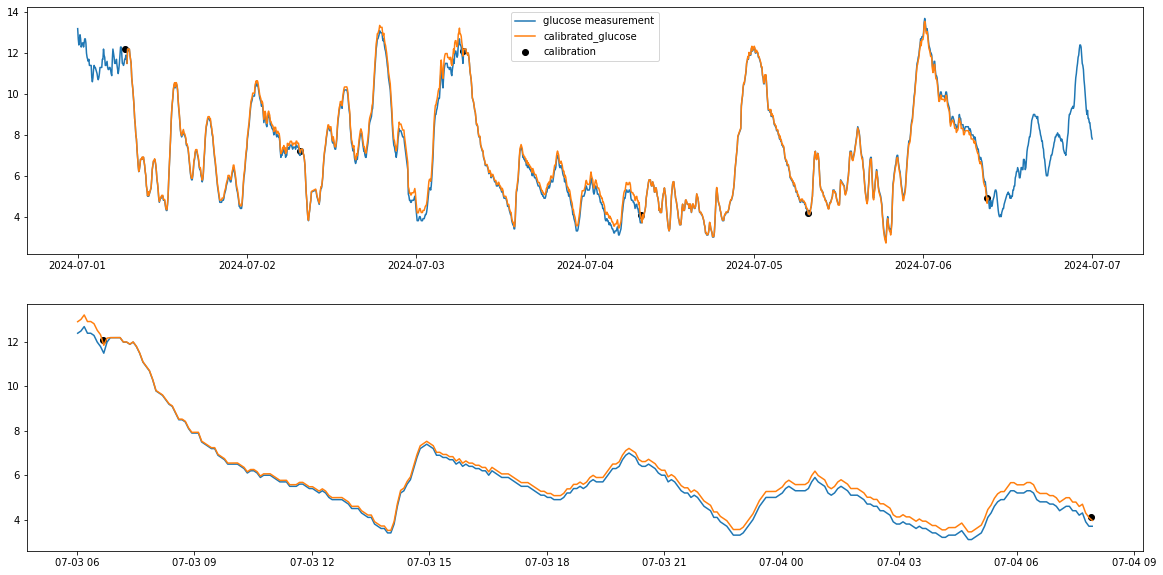

In [56]:
# It looks like it's working
fig, axs = plt.subplots(2)
fig.set_figheight(10)
fig.set_figwidth(20)

data = all_data[all_data['EventType'] == 'glucose_measurement'].copy()
axs[0].plot(data.index,data['Value'], label = 'glucose measurement')
axs[0].plot(data.index,data['calibrated_glucose'], label = 'calibrated_glucose')

data = all_data[all_data['EventType'] == 'calibration'].copy()
axs[0].scatter(data.index,data['Value'], label = 'calibration', color = 'k')

axs[0].legend()

fast_start = datetime(2024,7,3,6)
fast_end = datetime(2024,7,4,8)
data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == 'glucose_measurement')].copy()
axs[1].plot(data.index,data['Value'], label = 'glucose measurement')
axs[1].plot(data.index,data['calibrated_glucose'], label = 'calibrated_glucose')

data = all_data[(all_data.index < fast_end) & (all_data.index > fast_start) & (all_data['EventType'] == 'calibration')].copy()
axs[1].scatter(data.index,data['Value'], label = 'calibration', color = 'k')

In [60]:
# save the relevant data to a csv file to use later
all_data.loc[(all_data.index < fast_end) & (all_data.index > fast_start),['Value', 'EventType', 'calibrated_glucose']].copy().to_csv('fast_day.csv')

# Rapid insulin action curve

In this section I take advantage of the high night-time glucose value and the ensuing insulin injection. This event provides about 6 hours of glucose measurements where insuling is acting without any other influences.

I model the insulin action with an exponential decay. I assume that the time derivative of the glucose values behaves as

$$ g'(t) = - C - A \, \frac{t-t_0}{\tau^2} \, \text{e}^{-(t-t_0)/\tau} \theta(t-t_0)  \;,$$

with $\theta(t) = \frac{t+|t|}{2 t}$, the heavside function. $t_0$ is the time at which the insulin becomes active in the body. The second term on the right-hand-side can be interpreted as the insulin action. When it is zero, the glucose value only drifts and it can only decrease the glucose value. This model encodes the following phenomena:
- The delayed action of the insulin: Insulin takes some time to reach the blood stream and start to lower the sugar level. Moreover, the glucose reading from the sensor is also delayed because it actually measures the glucose concentration in the intersticial fluid instead of the blood. This feature is encoded in the $t-t_0$ argument of $f(t-t_0)$ with $t_0$ the time delay. In particular the heaveside function $\theta(t)$ ensures that $f(t-t_0)$ is zero as long as $t< t_0$.
- The amplitude of the effect of the shot on the body: More insulin will induce a larger decrease of blood sugar. This is encoded in the constant $A$ that I expect is proportional to the size of the injected dose. $A$ has the same physical unit as the glucose value, mmol/l.
- The decay of the effect of insulin over a few hours: Rapid insulin has an effect on the glucose level that rapidly ramps up at first and then stops after a few hours. This is encoded in the $t \exp(-t/\tau)$ part. For small values of $t$, this term is small and proportional to $t$. It grows and hits a maximum at $t= \tau$ and then decays exponentially. $\tau$ is the time scale of this phenomenon.
- The eventual effec of the long acting insulin: A long acting insulin that is not perfectly dosed will induce a slow drift of the glucose level. This effect is captured by the constant C.

This is very reasonable. The model however ignores the fact that the glucose value can not go below zero. In practice, this is rarely a problem because when it drops too low, then I compensate with some sugar. I have however noticed that there seems to be some kind of insulin resistance when $g$ is low. In particular, at times when the glucose value is dropping slowly, it never goes below about 3 mmol/l. From the above model (that is valid here because there are no other influences on the blood sugar and because the glucose value is quite high), we can infer the time-dependence of the glucose value as

$$g(t) = g_0 - C \, t - \theta(t-t_0) \, \frac{A}{\tau} \, \left[\tau-\text{e}^{-(t-t_0)/\tau} (t-t_0+\tau) \right] \, . $$

$g_0$ is the observed glucose value at $t=0$. This model has the following properties:
- $ g(t<t_0) = g_0 - C \,t $. Before the insulin kicks in, the glucose level linearily drifts.
- $g(t = t_0 + \epsilon) = g_0 - C \ (t_0 + \epsilon) + F(\epsilon) \cong g_0 - C \ (t_0 + \epsilon) - A \left(\frac{\epsilon}{\tau}\right)^2/2$, for $\epsilon \ll \tau$. The effect of the insulin kicks in smoothly as $(t-t_0)^2$. It is proportional to $A$.
- $g(t \gg \tau) = g_0 - C \, t - A$. The insulin injection decreases the glucose value by $A$.

Here, I fit the above model to my data and extract numerical values for $g_0$, $C$, $t_0$, $A$ and $\tau$.

In [7]:
# Get the data and extract the relevant part.
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

data = pd.read_csv('fast_day.csv').set_index('Unnamed: 0')
data.index = pd.to_datetime(data.index)
data.index.name = 'time'
# The insulin is acting alone immediately after my first (and only in this dataset) injection and right before I went to collect my daughter at kindergarden.
data = pd.concat([pd.DataFrame([[np.nan,np.nan,'glucose_measurement']],index = data[data['EventType'] == 'rapid_insulin_u'].index, columns = ['Value','calibrated_glucose','EventType']),data]).sort_index()
data = pd.concat([pd.DataFrame([[np.nan,np.nan,'glucose_measurement']],index = data[data['EventType'] == 'medium_exercise_min'].index, columns = ['Value','calibrated_glucose','EventType']),data]).sort_index()
data.loc[data['EventType'] == 'glucose_measurement',['Value','calibrated_glucose']] = data.loc[data['EventType'] == 'glucose_measurement',['Value','calibrated_glucose']].interpolate(method = 'time')
data = data.loc[(data['EventType'] == 'glucose_measurement') & (data.index >= data[data['EventType'] == 'rapid_insulin_u'].index[0]) & (data.index <= data[data['EventType'] == 'medium_exercise_min'].index[0]),['Value','calibrated_glucose']]
data['elapsed_time_h'] = (data.index-data.index[0]).total_seconds()/(3600)
data

,Value,calibrated_glucose
time,,
2024-07-03 06:44:00,11.80,12.050570
2024-07-03 06:46:00,12.00,12.179350
2024-07-03 06:51:00,12.20,12.200000
2024-07-03 06:56:00,12.20,12.201320
2024-07-03 07:01:00,12.20,12.202640
...,...,...
2024-07-03 11:51:00,5.50,5.579208
2024-07-03 11:56:00,5.40,5.480528
2024-07-03 12:01:00,5.40,5.481848


Mae and Mse fit scores [mmol/l]: 0.077 0.104
Slow drift [mmmol/(lh)]: 0.375
Over the total time below, the drift decrease the blod sugar by 2.038 mmol/l.
Action delay [minutes]: 28.524
Action time scale [minutes]: 41.236
Total glucose drop [mmol/l]: 4.859
Start and end values (without the drift) [mmol/l]: 12.25 7.391
After about 2.533 hours, the blood sugar has gone down by 80.0% of it total reduction.


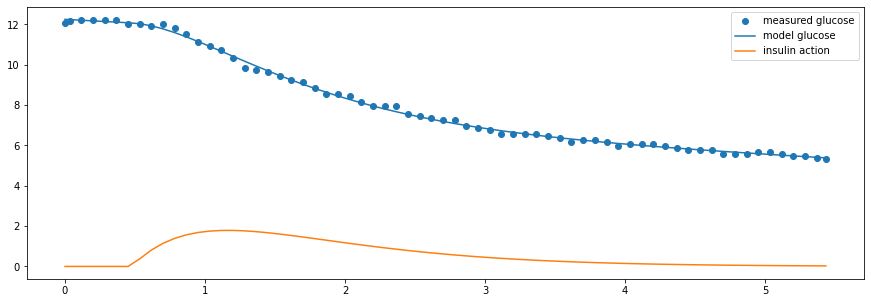

In [67]:
def theta(x):
    # I use a smooth version of the heavside function to avoid tripping the fit algorithm.
    scale = 0.01
    return (np.tanh(x/scale)+1)/2

def tofit(t,C, g0,t0,A,tau):
    # This is the model described above.
    return g0-C*t+theta(t-t0)*(A/tau)*(
        (tau+t-t0)*np.exp(-(t-t0)/tau)-tau
        )

def insulin_action(t,C, g0,t0,A,tau):
    # This is the insulin action. I multiply it by tau so that is has the same units as the glucose values (mmol/l).
    return tau*A*(t-t0)*theta(t-t0)*np.exp(-(t-t0)/tau)/(tau**2)

epsilon = 0.2
def to_zero(x):
    # finding x so that this returns zero provides the time when the glucose level has decreased by 1-epsilon.
    return (1+x)*np.exp(-x)-epsilon

popt, _ = curve_fit(tofit, data['elapsed_time_h'],data['calibrated_glucose'], p0 = [0, 12,0.75,11.5,0.6])
time_solution = fsolve(to_zero, 1)

fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)

axs.scatter(data['elapsed_time_h'],data['calibrated_glucose'], label = 'measured glucose')
axs.plot(data['elapsed_time_h'],tofit(data['elapsed_time_h'], *popt), label = 'model glucose')
axs.plot(data['elapsed_time_h'],insulin_action(data['elapsed_time_h'], *popt), label = 'insulin action')
axs.legend();

print('Mae and Mse fit scores [mmol/l]:',round(np.abs(data['calibrated_glucose']-tofit(data['elapsed_time_h'], *popt)).mean(),3), round((((data['calibrated_glucose']-tofit(data['elapsed_time_h'], *popt))**2).mean()**0.5),3))
print('Slow drift [mmmol/(lh)]:',round(popt[0],3))
print('Over the total time below, the drift decrease the blod sugar by',round(popt[0]*data.iloc[-1]['elapsed_time_h'],3),'mmol/l.')
print('Action delay [minutes]:', round(popt[2]*60,3))
print('Action time scale [minutes]:', round(popt[4]*60,3))
print('Total glucose drop [mmol/l]:',round(popt[3],3))
print('Start and end values (without the drift) [mmol/l]:',round(popt[1],3),round(popt[1]-popt[3],3))
print('After about',round(popt[2]+popt[4]*time_solution[0],3),'hours, the blood sugar has gone down by', str(100*(1-epsilon))+'% of it total reduction.')

I try below an alternative model with

$$ g'(t) = - C - A \, \frac{t-t_0}{\tau^2} \, \text{e}^{-[(t-t_0)/\tau]^2} \theta(t-t_0)  \;.$$

It works in the same way as the model described above, but the obtained numerical values and fit score are not quite as good.

Mae and Mse fit scores [mmol/l]: 0.093 0.13
Slow drift [mmmol/(lh)]: 0.527
Over the total time below, the drift decrease the blod sugar by 2.865 mmol/l.
Action delay [minutes]: 16.104
Action time scale [minutes]: 93.711
Total glucose drop [mmol/l]: 4.131
Start and end values (without the drift) [mmol/l]: 12.329 4.066
After about 4.231 hours, the blood sugar has gone down by 80.0% of it total reduction.


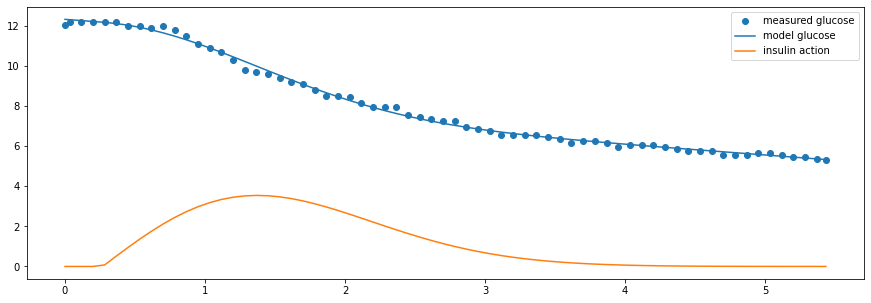

In [66]:
def tofit_square(t,C, g0,t0,A,tau):
    # This is an alternative model.
    return g0-C*t-theta(t-t0)*A*(1-np.exp(-(t-t0)**2/tau**2))/2

def insulin_action_square(t,C, g0,t0,A,tau):
    # This is the corresponding insulin action. I multiply it by tau so that is has the same units as the glucose values (mmol/l).
    return tau*A*(t-t0)*theta(t-t0)*np.exp(-(t-t0)**2/tau**2)/(tau**2)

popt, _ = curve_fit(tofit_square, data['elapsed_time_h'],data['calibrated_glucose'], p0 = [0, 12,0.75,11.5,0.6])
epsilon = 0.2
time_solution = [2*(-np.log(epsilon))**0.5]

fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)

axs.scatter(data['elapsed_time_h'],data['calibrated_glucose'], label = 'measured glucose')
axs.plot(data['elapsed_time_h'],tofit_square(data['elapsed_time_h'], *popt), label = 'model glucose')
axs.plot(data['elapsed_time_h'],insulin_action_square(data['elapsed_time_h'], *popt), label = 'insulin action')
axs.legend();

print('Mae and Mse fit scores [mmol/l]:',round(np.abs(data['calibrated_glucose']-tofit_square(data['elapsed_time_h'], *popt)).mean(),3), round((((data['calibrated_glucose']-tofit_square(data['elapsed_time_h'], *popt))**2).mean()**0.5),3))
print('Slow drift [mmmol/(lh)]:',round(popt[0],3))
print('Over the total time below, the drift decrease the blod sugar by',round(popt[0]*data.iloc[-1]['elapsed_time_h'],3),'mmol/l.')
print('Action delay [minutes]:', round(popt[2]*60,3))
print('Action time scale [minutes]:', round(popt[4]*60,3))
print('Total glucose drop [mmol/l]:',round(popt[3]/2,3))
print('Start and end values (without the drift) [mmol/l]:',round(popt[1],3),round(popt[1]-popt[3],3))
print('After about',round(popt[2]+popt[4]*time_solution[0],3),'hours, the blood sugar has gone down by', str(100*(1-epsilon))+'% of it total reduction.')

I see from this analysis that my long acting insulin is a bit overdosed. I could lessen the drift term by injecting a little less of it. I will also keep in mind the time scale of 2.533 hours for the action of the rapid insulin. For now, I have the following questions:

- How does this depend on the amount of insulin injected? Assuming that A is proportional to the number of clicks, then I have a glucose decrease of about 1.630 mmol/(l*click). Is this a good assumption?
- How does this depend on the time of the day? My body surely reacts differently at different times.
- Where can I find insulin action curves in the litterature? I would like to compare this to something.

# Food action curve

In this section, I repeat the above analysis on insulin action, but with my sugar intakes. During the fast day, I ate carbohydrates 4 times. 3 of them were white sugar (fast acting) and one was dark chocolate (slow acting). All these events were in the second half of the day and can be assumed to be independent of the rapid acting insulin injection. One of the rapid sugar intakes corresponds to a high intensity exercise event and will be discarded. The other 3 events are assumed to be independent from insulin and exercise. I will be analyse the one after the other. The model is essentially the same as before

$$ g'(t) = - C + A \, \frac{t-t_0}{\tau^2} \, \text{e}^{-(t-t_0)/\tau} \theta(t-t_0)  \;,$$

with the difference that the glucose level goes up this time. $t_0$ only reflects the delay in the sensor measurement and is expected to be smaller this time.

In [99]:
# Get the data and extract the relevant part.
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

data = pd.read_csv('fast_day.csv').set_index('Unnamed: 0')
data.index = pd.to_datetime(data.index)
data.index.name = 'time'
data = data.sort_index()

# Make a dictionary with the three carb intake events.
carb_events_start = [data[data['EventType'] == 'rapid_glucose_g'].index[0], data[data['EventType'] == 'slow_glucose_g'].index[0], data[data['EventType'] == 'rapid_glucose_g'].index[-1]]
events = {}
for ev in carb_events_start:
    ev_end = data[(data['EventType'] != 'glucose_measurement') & (data['EventType'] != 'calibration') & (data.index >= ev)].iloc[1].name
    data = pd.concat([pd.DataFrame([[np.nan,np.nan,'glucose_measurement']],index = [ev,ev_end], columns = ['Value','calibrated_glucose','EventType']),data]).sort_index()
    data.loc[data['EventType'] == 'glucose_measurement',['Value','calibrated_glucose']] = data.loc[data['EventType'] == 'glucose_measurement',['Value','calibrated_glucose']].interpolate(method = 'time')

    temp = data.loc[(data.index <= ev_end) & (data.index >= ev) & (data['EventType'] == 'glucose_measurement'),['Value','calibrated_glucose']].sort_index()
    temp['elapsed_time_h'] = (temp.index-temp.index[0]).total_seconds()/(3600)
    temp.index.name = ev
    events[ev] = temp

In [100]:
def theta(x):
    # I use a smooth version of the heavside function to avoid tripping the fit algorithm.
    scale = 0.01
    return (np.tanh(x/scale)+1)/2

def tofit(t,C, g0,t0,A,tau):
    # This is the model described above.
    return g0-C*t-theta(t-t0)*(A/tau)*(
        (tau+t-t0)*np.exp(-(t-t0)/tau)-tau
        )

def glucose_action(t,C, g0,t0,A,tau):
    # This is the insulin action. I multiply it by tau so that is has the same units as the glucose values (mmol/l).
    return tau*A*(t-t0)*theta(t-t0)*np.exp(-(t-t0)/tau)/(tau**2)

epsilon = 0.2
def to_zero(x):
    # finding x so that this returns zero provides the time when the glucose level has decreased by 1-epsilon.
    return (1+x)*np.exp(-x)-epsilon

Mae and Mse fit scores [mmol/l]: 0.114 0.158
Slow drift [mmmol/(lh)]: 0.709
Over the total time below, the drift decrease the blod sugar by 3.049 mmol/l.
Action delay [minutes]: 21.142
Action time scale [minutes]: 12.934
Total glucose increase [mmol/l]: 4.516
Start and end values (without the drift) [mmol/l]: 3.819 8.335
After about 0.998 hours, the blood sugar has gone up by 80.0% of it total increase.


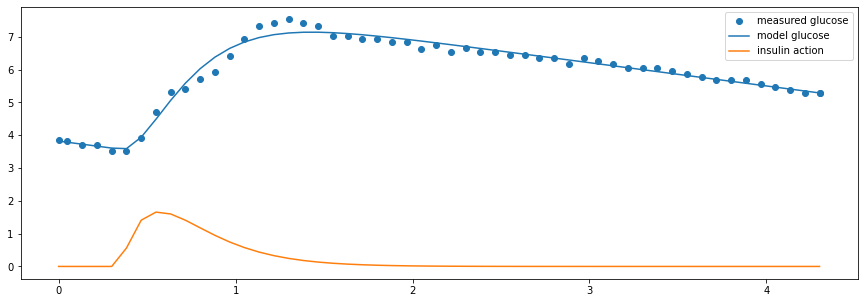

In [111]:
data = list(events.values())[0]

popt, _ = curve_fit(tofit, data['elapsed_time_h'],data['calibrated_glucose'], p0 = [0, 12,0.75,11.5,0.6])
time_solution = fsolve(to_zero, 1)

fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)

axs.scatter(data['elapsed_time_h'],data['calibrated_glucose'], label = 'measured glucose')
axs.plot(data['elapsed_time_h'],tofit(data['elapsed_time_h'], *popt), label = 'model glucose')
axs.plot(data['elapsed_time_h'],insulin_action(data['elapsed_time_h'], *popt), label = 'insulin action')
axs.legend();

print('Mae and Mse fit scores [mmol/l]:',round(np.abs(data['calibrated_glucose']-tofit(data['elapsed_time_h'], *popt)).mean(),3), round((((data['calibrated_glucose']-tofit(data['elapsed_time_h'], *popt))**2).mean()**0.5),3))
print('Slow drift [mmmol/(lh)]:',round(popt[0],3))
print('Over the total time below, the drift decrease the blod sugar by',round(popt[0]*data.iloc[-1]['elapsed_time_h'],3),'mmol/l.')
print('Action delay [minutes]:', round(popt[2]*60,3))
print('Action time scale [minutes]:', round(popt[4]*60,3))
print('Total glucose increase [mmol/l]:',round(popt[3],3))
print('Start and end values (without the drift) [mmol/l]:',round(popt[1],3),round(popt[1]+popt[3],3))
print('After about',round(popt[2]+popt[4]*time_solution[0],3),'hours, the blood sugar has gone up by', str(100*(1-epsilon))+'% of it total increase.')

Mae and Mse fit scores [mmol/l]: 0.158 0.191
Slow drift [mmmol/(lh)]: 0.705
Over the total time below, the drift decrease the blod sugar by 4.288 mmol/l.
Action delay [minutes]: 19.478
Action time scale [minutes]: 26.603
Total glucose increase [mmol/l]: 3.737
Start and end values (without the drift) [mmol/l]: 3.893 7.63
After about 1.652 hours, the blood sugar has gone up by 80.0% of it total increase.


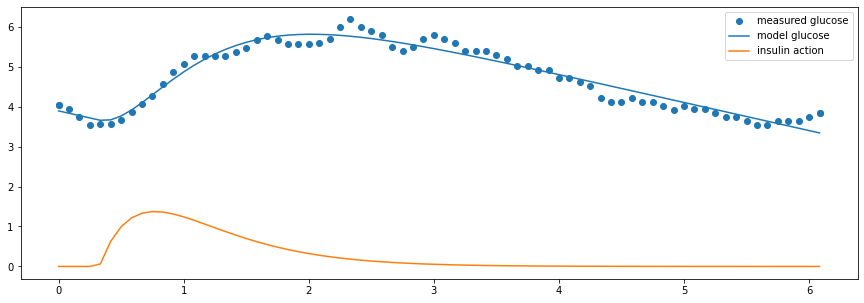

In [112]:
data = list(events.values())[1]

popt, _ = curve_fit(tofit, data['elapsed_time_h'],data['calibrated_glucose'], p0 = [0, 12,0.75,11.5,0.6])
time_solution = fsolve(to_zero, 1)

fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)

axs.scatter(data['elapsed_time_h'],data['calibrated_glucose'], label = 'measured glucose')
axs.plot(data['elapsed_time_h'],tofit(data['elapsed_time_h'], *popt), label = 'model glucose')
axs.plot(data['elapsed_time_h'],insulin_action(data['elapsed_time_h'], *popt), label = 'insulin action')
axs.legend();

print('Mae and Mse fit scores [mmol/l]:',round(np.abs(data['calibrated_glucose']-tofit(data['elapsed_time_h'], *popt)).mean(),3), round((((data['calibrated_glucose']-tofit(data['elapsed_time_h'], *popt))**2).mean()**0.5),3))
print('Slow drift [mmmol/(lh)]:',round(popt[0],3))
print('Over the total time below, the drift decrease the blod sugar by',round(popt[0]*data.iloc[-1]['elapsed_time_h'],3),'mmol/l.')
print('Action delay [minutes]:', round(popt[2]*60,3))
print('Action time scale [minutes]:', round(popt[4]*60,3))
print('Total glucose increase [mmol/l]:',round(popt[3],3))
print('Start and end values (without the drift) [mmol/l]:',round(popt[1],3),round(popt[1]+popt[3],3))
print('After about',round(popt[2]+popt[4]*time_solution[0],3),'hours, the blood sugar has gone up by', str(100*(1-epsilon))+'% of it total increase.')

Mae and Mse fit scores [mmol/l]: 0.187 0.23
Slow drift [mmmol/(lh)]: -1.674
Over the total time below, the drift decrease the blod sugar by -5.636 mmol/l.
Action delay [minutes]: 63.786
Action time scale [minutes]: 98.823
Total glucose increase [mmol/l]: -12.02
Start and end values (without the drift) [mmol/l]: 3.407 -8.613
After about 5.995 hours, the blood sugar has gone up by 80.0% of it total increase.


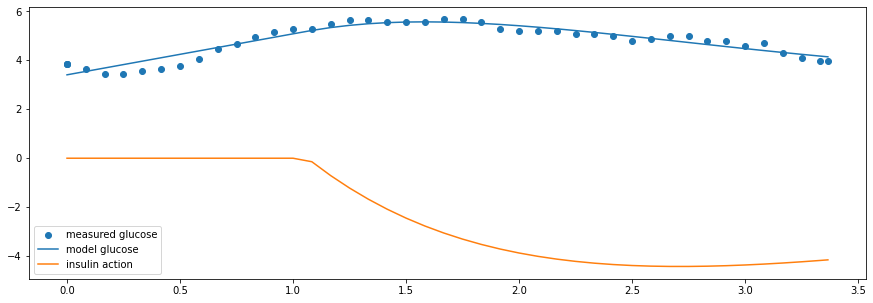

In [113]:
data = list(events.values())[2]

popt, _ = curve_fit(tofit, data['elapsed_time_h'],data['calibrated_glucose'], p0 = [0, 12,0.75,11.5,0.6])
time_solution = fsolve(to_zero, 1)

fig, axs = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)

axs.scatter(data['elapsed_time_h'],data['calibrated_glucose'], label = 'measured glucose')
axs.plot(data['elapsed_time_h'],tofit(data['elapsed_time_h'], *popt), label = 'model glucose')
axs.plot(data['elapsed_time_h'],insulin_action(data['elapsed_time_h'], *popt), label = 'insulin action')
axs.legend();

print('Mae and Mse fit scores [mmol/l]:',round(np.abs(data['calibrated_glucose']-tofit(data['elapsed_time_h'], *popt)).mean(),3), round((((data['calibrated_glucose']-tofit(data['elapsed_time_h'], *popt))**2).mean()**0.5),3))
print('Slow drift [mmmol/(lh)]:',round(popt[0],3))
print('Over the total time below, the drift decrease the blod sugar by',round(popt[0]*data.iloc[-1]['elapsed_time_h'],3),'mmol/l.')
print('Action delay [minutes]:', round(popt[2]*60,3))
print('Action time scale [minutes]:', round(popt[4]*60,3))
print('Total glucose increase [mmol/l]:',round(popt[3],3))
print('Start and end values (without the drift) [mmol/l]:',round(popt[1],3),round(popt[1]+popt[3],3))
print('After about',round(popt[2]+popt[4]*time_solution[0],3),'hours, the blood sugar has gone up by', str(100*(1-epsilon))+'% of it total increase.')

# Effect of exercise

todo